## Ensemble Modeling for Titanic Survivors

**Columns**:
- **PassengerId**
- **Survived**: 0 = No; 1 = Yes
- **Pclass**: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- **Name**
- **Sex**
- **Age**
- **SibSp**: Number of Siblings/Spouses Aboard
- **Parch**: Number of Parents/Children Aboard
- **Ticket**
- **Fare**: Passenger fare
- **Cabin**
- **Embarked**: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

**Table of Contents**:

1. [Data Preparation]
2. [Data Cleaning and Processing]
3. [EDA (Exploratory Data Analysis)]
    - Outliers
    - Imputation (Null/NA value handling)
4. [Modeling]

## Data Preparation

### Import Libraries

In [1]:
# DATA MANIPULATION
import numpy as np
import pandas as pd

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# SYSTEM
import os

# Modeling
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# TOOLS
from collections import Counter

# SETTINGS
plt.style.use('ggplot')

# DIRECTORIES        
DATA_DIR = os.path.join(os.getcwd(), 'kaggle', 'input', 'titanic')
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')

### Import Datasets

In [2]:
df = pd.read_csv(TRAIN_PATH)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
df.to_numpy().shape

(891,)

### Column Types

In [660]:
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categ_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked']

### Encoding/Decoding

In [661]:
def class_str(Pclass):
    if Pclass == 1: return 'First'
    elif Pclass == 2: return 'Second'
    else: return 'Third'
df['Class'] = df['Pclass'].apply(class_str)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Third
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,First
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Third
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,First
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Third


## Data Cleaning and Processing

### Outliers

In [662]:
def tukey(df, n, features):
    outliers_idx = []
    for feat in features:
        Q1 = np.percentile(df[feat], 25)
        Q3 = np.percentile(df[feat], 75)
        IQR = Q3-Q1
        threshold = 1.5 * IQR
        outlier_rows = df[(df[feat] < Q1 - threshold) | (df[feat] > Q3 + threshold)].index
        outliers_idx.extend(outlier_rows)
    outlier_indices = Counter(outliers_idx)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers
outliers = tukey(df, 2, num_cols)
df.iloc[outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Class
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S,First
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S,First
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,Third
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,Third
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,Third
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,Third
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S,First
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,Third
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,Third
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,Third


In [663]:
df = df.drop(outliers, axis=0).reset_index(drop=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Third
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,First
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Third
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,First
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Third
...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Second
877,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,First
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Third
879,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,First


### Imputation

In [664]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
 12  Class        881 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 89.6+ KB


In [665]:
df = df.fillna(np.nan)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
Class            0
dtype: int64

In [666]:
df['Embarked'] = df['Embarked'].fillna('S')

### Summary

- **Outliers**
  - Used Tukey's Method (removing $Q1 - 1.5*\text{IQR} < \text{value} < Q3 + 1.5 * \text{IQR}$)
- **Imputation**
  - Columns: Number of null values
    - Age: 177
    - Cabin: 687
    - Embarked: 2

## EDA

### Statistics

In [667]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [668]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked,Class
count,881,881,881,201,881,881
unique,881,2,680,147,3,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S,Third
freq,1,572,7,4,636,484


### Univariate

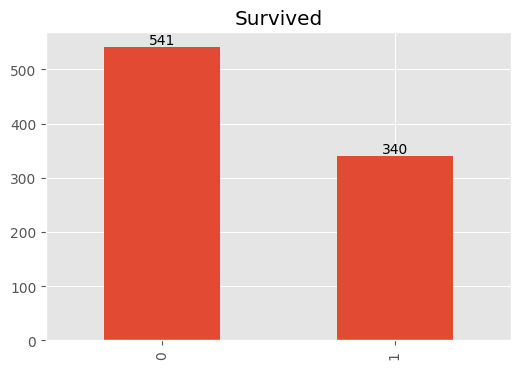

In [669]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
bar = df['Survived'].value_counts().plot(kind='bar')
for bar in ax.containers:
    ax.bar_label(bar)
ax.set_title("Survived")
plt.show()

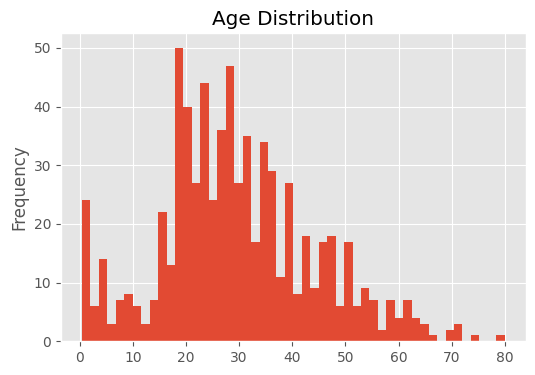

In [670]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
bar = df['Age'].plot.hist(bins=50)
ax.set_title("Age Distribution")
plt.show()

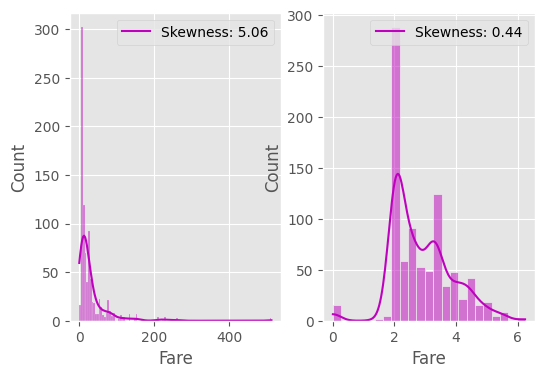

In [671]:
fig, axs = plt.subplots(1, 2, figsize=(6,4))
axs = axs.flatten()
sns.histplot(df["Fare"], color="m", kde=True, ax=axs[0])
axs[0].legend([f"Skewness: {df['Fare'].skew():.2f}"])
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
sns.histplot(df["Fare"], color="m", kde=True, ax=axs[1])
axs[1].legend([f"Skewness: {df['Fare'].skew():.2f}"])
plt.show()

### Bivariate

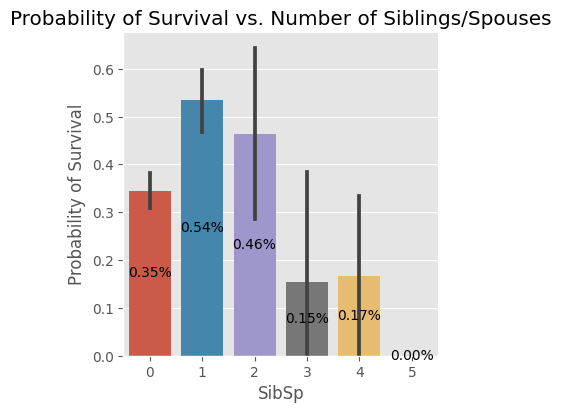

In [672]:
g = sns.catplot(data=df, x='SibSp', y='Survived', kind='bar', height=4).set(title="Probability of Survival vs. Number of Siblings/Spouses")
g = g.set_ylabels("Probability of Survival")
ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{v.get_height():.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

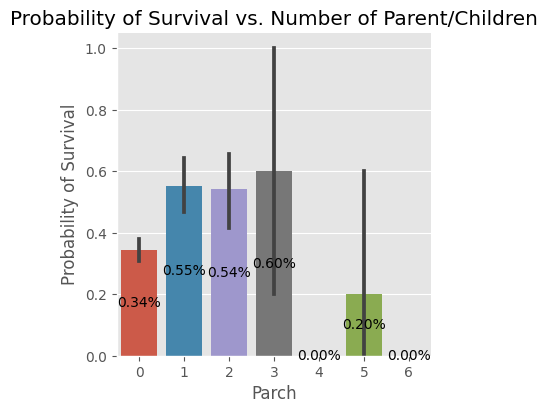

In [673]:
g = sns.catplot(data=df, x='Parch', y='Survived', kind='bar', height=4).set(title="Probability of Survival vs. Number of Parent/Children")
g = g.set_ylabels("Probability of Survival")
ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{v.get_height():.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

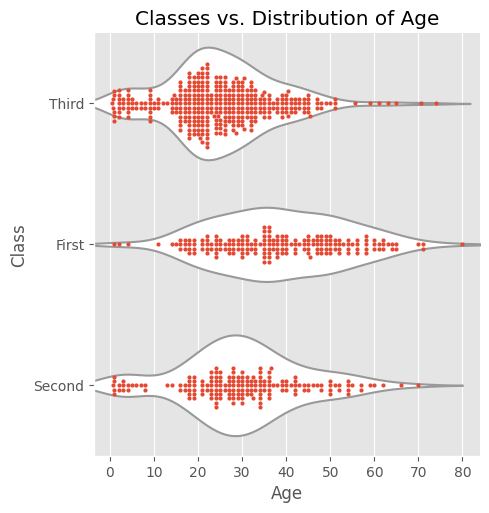

In [674]:
sns.catplot(data=df, x="Age", y="Class", kind="violin", color="1", inner=None).set(title="Classes vs. Distribution of Age")
sns.swarmplot(data=df, x="Age", y="Class", size=3)
plt.show()

### Multivariate

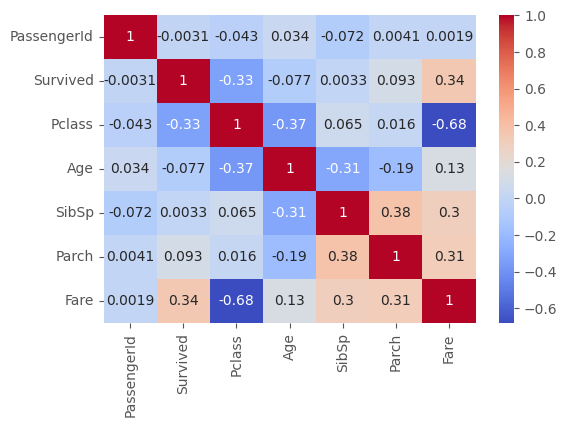

In [675]:
plt.figure(figsize=(6,4))
heat = sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

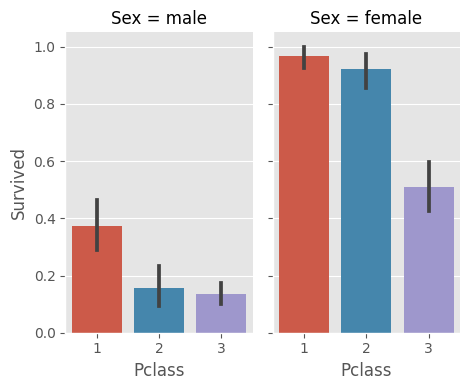

In [676]:
sns.catplot(data=df, x="Pclass", y="Survived", col="Sex", kind="bar", height=4, aspect=.6)
plt.show()

### Summary

## Feature Engineering

### Sex

In [677]:
df['Sex'] = df['Sex'].astype('category').cat.codes
df['Sex'].head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int8

### Age

In [678]:
nan_indices = list(df["Age"][df["Age"].isnull()].index)

for i in nan_indices:
    age_med = df["Age"].median()
    age_pred = df["Age"][((df['SibSp'] == df.loc[i, "SibSp"]) & (df['Parch'] == df.loc[i, "Parch"]) & (df['Pclass'] == df.loc[i, "Pclass"]))].median()
    if not np.isnan(age_pred):
        df.loc[i, 'Age'] = age_pred
    else:
        df.loc[i, 'Age'] = age_med

In [679]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         0
Class            0
dtype: int64

### Name

In [680]:
df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
876                                Montvila, Rev. Juozas
877                         Graham, Miss. Margaret Edith
878             Johnston, Miss. Catherine Helen "Carrie"
879                                Behr, Mr. Karl Howell
880                                  Dooley, Mr. Patrick
Name: Name, Length: 881, dtype: object

In [681]:
df["Titles"] = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Titles"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Titles, dtype: object

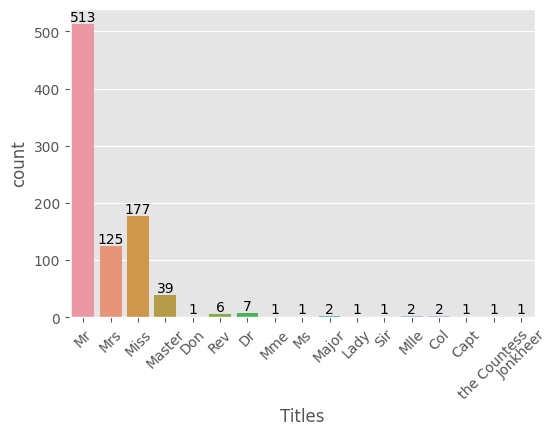

In [682]:
plt.figure(figsize=(6,4))
g = sns.countplot(x="Titles", data=df)
for c in g.containers:
    labels = [f'{int(v.get_height())}' for v in c]
    g.bar_label(c, labels=labels, label_type='edge')
g = plt.setp(g.get_xticklabels(), rotation=45) 

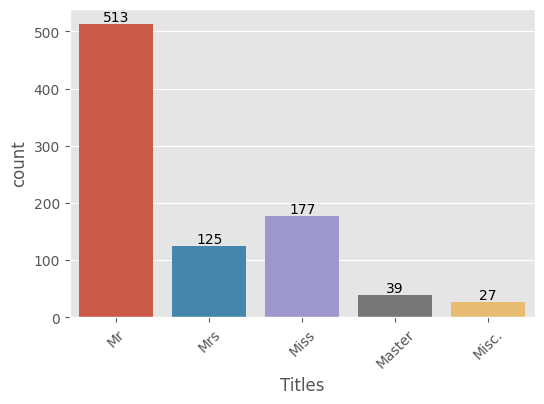

In [683]:
title_count = df['Titles'].value_counts()
df.loc[df['Titles'].isin(title_count[title_count < 30].index), 'Titles'] = 'Misc.'
plt.figure(figsize=(6,4))
g = sns.countplot(x="Titles", data=df)
for c in g.containers:
    labels = [f'{int(v.get_height())}' for v in c]
    g.bar_label(c, labels=labels, label_type='edge')
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [684]:
df = pd.get_dummies(df, columns = ["Titles"],prefix="Title")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Class,Title_Master,Title_Misc.,Title_Miss,Title_Mr,Title_Mrs
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,NaN,S,Third,0,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,C85,C,First,0,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,Third,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.972177,C123,S,First,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.085672,NaN,S,Third,0,0,0,1,0


### Cabin

In [685]:
df['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
876     NaN
877     B42
878     NaN
879    C148
880     NaN
Name: Cabin, Length: 881, dtype: object

In [686]:
df['Cabin'] = ['X' if pd.isnull(i) else i[0] for i in df['Cabin']]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Class,Title_Master,Title_Misc.,Title_Miss,Title_Mr,Title_Mrs
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,X,S,Third,0,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,C,C,First,0,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.070022,X,S,Third,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.972177,C,S,First,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.085672,X,S,Third,0,0,0,1,0


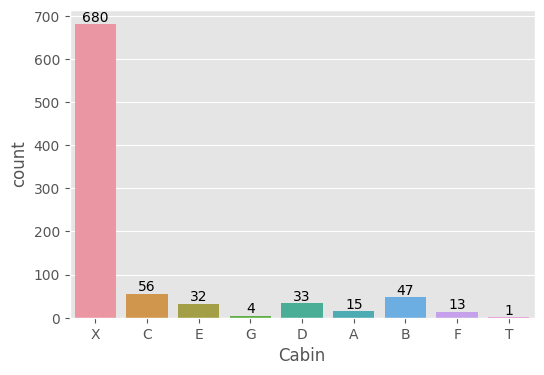

In [687]:
plt.figure(figsize=(6,4))
g = sns.countplot(x="Cabin", data=df)
for c in g.containers:
    labels = [f'{int(v.get_height())}' for v in c]
    g.bar_label(c, labels=labels, label_type='edge')

In [688]:
df = pd.get_dummies(df, columns = ["Cabin"],prefix="Cabin")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Mrs,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,...,1,0,0,1,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.070022,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.972177,...,1,0,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.085672,...,0,0,0,0,0,0,0,0,0,1


### Ticket

In [689]:
df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
876              211536
877              112053
878          W./C. 6607
879              111369
880              370376
Name: Ticket, Length: 881, dtype: object

In [690]:
df['Ticket'] = [i.replace(".","").replace("/","").strip().split(' ')[0] if not i.isdigit() else 'X' for i in df['Ticket']]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Mrs,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A5,1.981001,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC,4.266662,...,1,0,0,1,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STONO2,2.070022,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,X,3.972177,...,1,0,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,X,2.085672,...,0,0,0,0,0,0,0,0,0,1


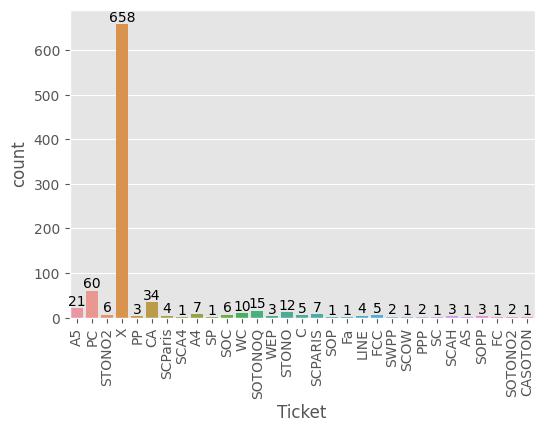

In [691]:
plt.figure(figsize=(6,4))
g = sns.countplot(x="Ticket", data=df)
for c in g.containers:
    labels = [f'{int(v.get_height())}' for v in c]
    g.bar_label(c, labels=labels, label_type='edge')
g = plt.setp(g.get_xticklabels(), rotation=90)

In [692]:
df = pd.get_dummies(df, columns = ["Ticket"], prefix="T")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,...,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_SWPP,T_WC,T_WEP,T_X
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,1.981001,S,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,4.266662,C,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,2.070022,S,...,0,0,0,0,0,1,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,3.972177,S,...,0,0,0,0,0,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,2.085672,S,...,0,0,0,0,0,0,0,0,0,1


### Embarked

In [693]:
df = pd.get_dummies(df, columns = ["Embarked"],prefix="Embarked")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Class,...,T_SP,T_STONO,T_STONO2,T_SWPP,T_WC,T_WEP,T_X,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,1.981001,Third,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,4.266662,First,...,0,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,2.070022,Third,...,0,0,1,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,3.972177,First,...,0,0,0,0,0,0,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,2.085672,Third,...,0,0,0,0,0,0,1,0,0,1


### Pclass

In [694]:
df = pd.get_dummies(df, columns = ["Pclass"],prefix="Pclass")
df.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Fare,Class,Title_Master,...,T_SWPP,T_WC,T_WEP,T_X,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,1.981001,Third,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,4.266662,First,0,...,0,0,0,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,2.070022,Third,0,...,0,0,0,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,3.972177,First,0,...,0,0,0,1,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,2.085672,Third,0,...,0,0,0,1,0,0,1,0,0,1


## Model Selection

In [695]:
X_train = df.drop(columns=['Survived', 'Name', 'Class'])
y_train = df['Survived']
X_train

,PassengerId,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Misc.,Title_Miss,Title_Mr,...,T_SWPP,T_WC,T_WEP,T_X,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,1,22.0,1,0,1.981001,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,2,0,38.0,1,0,4.266662,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,3,0,26.0,0,0,2.070022,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,4,0,35.0,1,0,3.972177,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
4,5,1,35.0,0,0,2.085672,0,0,0,1,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,1,27.0,0,0,2.564949,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
877,888,0,19.0,0,0,3.401197,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0
878,889,0,13.5,1,2,3.154870,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
879,890,1,26.0,0,0,3.401197,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0


In [696]:
random_state = 42
classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state = random_state),
    LinearDiscriminantAnalysis(),
    XGBClassifier(),
    LGBMClassifier()
]
classifier_names = [
    "SVC",
    "DecisionTree",
    "AdaBoost",
    "RandomForest",
    "ExtraTrees",
    "GradientBoosting",
    "MultipleLayerPerceptron",
    "KNeighbors",
    "LogisticRegression",
    "LinearDiscriminantAnalysis",
    "XGBoost",
    "LGBM",
]

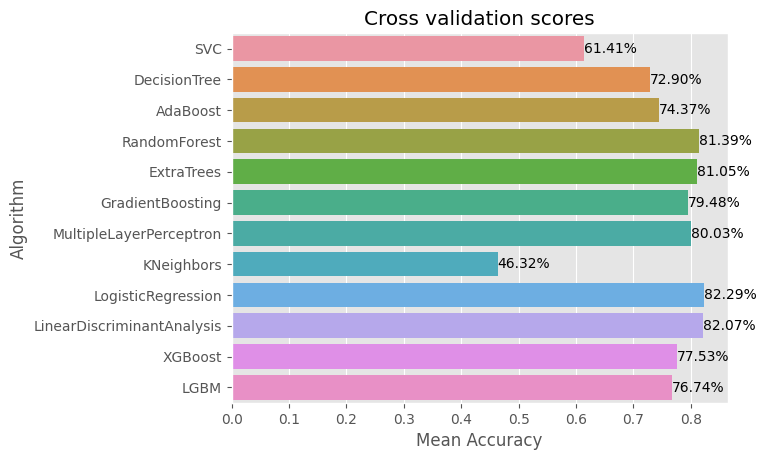

In [697]:
cv_results = []
kfold = StratifiedKFold(n_splits=10)

for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring = "accuracy", cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm": classifier_names})

g = sns.barplot(data=cv_res, x="CrossValMeans", y="Algorithm")
g.set_xlabel("Mean Accuracy")
for c in g.containers:
    labels = [f'{v.get_width()*100:.2f}%' for v in c]
    g.bar_label(c, labels=labels, label_type='edge')
g = g.set_title("Cross validation scores")

## Modeling

In [698]:
classifier_models = [
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    LogisticRegression(random_state = random_state),
    LinearDiscriminantAnalysis(),
]
classifier_names = [
    "RandomForest",
    "ExtraTrees",
    "LogisticRegression",
    "LinearDiscriminantAnalysis",
]
classifiers = dict(zip(classifier_names, classifier_models))

In [ ]:
model = "RandomForest"
parameters = {

}